# 05__mpranalyze_compare

in this notebook, i run MPRAnalyze in 'compare' mode to get log2 foldchanges and p-values between (a) sequence orthologs and (b) cell types.

In [1]:
# # install MPRAnalyze
# if (!requireNamespace("BiocManager", quietly = TRUE))
#   install.packages("BiocManager")
# BiocManager::install("MPRAnalyze", version = "3.8")

In [2]:
# # install RCurl
# install.packages("RCurl")

In [3]:
# # install biocparallel
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("BiocParallel")

In [4]:
# load the package
library(MPRAnalyze)
library(tidyr)

In [5]:
library(BiocParallel)

## 1. load data

### first load data for library depth correction

In [6]:
dna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)

# since we only have 1 dna replicate -- add another so code doesn't crash (expects matrix)
dna_counts_depth["dna_2"] <- dna_counts_depth["dna_1"]

row.names(dna_counts_depth) <- dna_counts_depth$element
dna_counts_depth <- dna_counts_depth[ , !(names(dna_counts_depth) %in% c("element")), drop=FALSE]
dna_counts_depth <- as.matrix(dna_counts_depth)

In [7]:
rna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
row.names(rna_counts_depth) <- rna_counts_depth$element
rna_counts_depth <- rna_counts_depth[ , !(names(rna_counts_depth) %in% c("element")), drop=FALSE]
rna_counts_depth <- as.matrix(rna_counts_depth)

In [8]:
dna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(dna_cols_depth) <- c("id", "condition", "sample")

# add second row to dna_cols_depth
row2 <- data.frame(id="dna_2", condition="dna", sample="2")
dna_cols_depth <- rbind(dna_cols_depth, row2)
row.names(dna_cols_depth) <- dna_cols_depth$id

rna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(rna_cols_depth) <- c("id", "condition", "sample")
row.names(rna_cols_depth) <- rna_cols_depth$id
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<int>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


In [9]:
# make sure everything is a factor
dna_cols_depth$condition <- as.factor(dna_cols_depth$condition)
rna_cols_depth$condition <- as.factor(rna_cols_depth$condition)
rna_cols_depth$sample <- as.factor(rna_cols_depth$sample)
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<fct>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


### then data to model: first, DNA (same for all models)

In [10]:
all_comp_dna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_counts) <- all_comp_dna_counts$comp_id
all_comp_dna_counts <- all_comp_dna_counts[ , !(names(all_comp_dna_counts) %in% c("comp_id"))]
all_comp_dna_counts <- as.matrix(all_comp_dna_counts)

In [11]:
all_comp_dna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_cols) <- all_comp_dna_cols$X
head(all_comp_dna_cols)

,X,condition,barcode,seq
,<fct>,<fct>,<int>,<fct>
samp:dna_1__barc:10___seq:human,samp:dna_1__barc:10___seq:human,dna,10,human
samp:dna_1__barc:10___seq:mouse,samp:dna_1__barc:10___seq:mouse,dna,10,mouse
samp:dna_1__barc:11___seq:human,samp:dna_1__barc:11___seq:human,dna,11,human
samp:dna_1__barc:11___seq:mouse,samp:dna_1__barc:11___seq:mouse,dna,11,mouse
samp:dna_1__barc:12___seq:human,samp:dna_1__barc:12___seq:human,dna,12,human
samp:dna_1__barc:12___seq:mouse,samp:dna_1__barc:12___seq:mouse,dna,12,mouse


In [12]:
all_comp_dna_cols$barcode <- as.factor(all_comp_dna_cols$barcode)
all_comp_dna_cols$seq <- as.factor(all_comp_dna_cols$seq)
all_comp_dna_cols$condition <- as.factor(all_comp_dna_cols$condition)
all_comp_dna_cols

,X,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>
samp:dna_1__barc:10___seq:human,samp:dna_1__barc:10___seq:human,dna,10,human
samp:dna_1__barc:10___seq:mouse,samp:dna_1__barc:10___seq:mouse,dna,10,mouse
samp:dna_1__barc:11___seq:human,samp:dna_1__barc:11___seq:human,dna,11,human
samp:dna_1__barc:11___seq:mouse,samp:dna_1__barc:11___seq:mouse,dna,11,mouse
samp:dna_1__barc:12___seq:human,samp:dna_1__barc:12___seq:human,dna,12,human
samp:dna_1__barc:12___seq:mouse,samp:dna_1__barc:12___seq:mouse,dna,12,mouse
samp:dna_1__barc:13___seq:human,samp:dna_1__barc:13___seq:human,dna,13,human
samp:dna_1__barc:13___seq:mouse,samp:dna_1__barc:13___seq:mouse,dna,13,mouse
samp:dna_1__barc:1___seq:human,samp:dna_1__barc:1___seq:human,dna,1,human


### then controls (same for all models)

In [13]:
all_comp_ctrls <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/ctrl_status.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
all_comp_ctrls <- as.logical(all_comp_ctrls$ctrl_status)
head(all_comp_ctrls)

[1] FALSE FALSE FALSE FALSE FALSE FALSE

In [14]:
length(all_comp_ctrls)

[1] 3334

### then data to model: native effects

In [15]:
native_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/native_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(native_rna_counts) <- native_rna_counts$comp_id
native_rna_counts <- native_rna_counts[ , !(names(native_rna_counts) %in% c("comp_id"))]
native_rna_counts <- as.matrix(native_rna_counts)

In [16]:
native_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/native_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(native_rna_cols) <- native_rna_cols$X
head(native_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<int>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


In [17]:
# make sure everything is a factor
native_rna_cols$barcode <- as.factor(native_rna_cols$barcode)
native_rna_cols$seq <- as.factor(native_rna_cols$seq)
native_rna_cols$condition <- as.factor(native_rna_cols$condition)
head(native_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


### cis+ trans interactions

In [18]:
all_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/all_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_rna_counts) <- all_rna_counts$comp_id
all_rna_counts <- all_rna_counts[ , !(names(all_rna_counts) %in% c("comp_id"))]
all_rna_counts <- as.matrix(all_rna_counts)

In [19]:
all_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/all_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_rna_cols) <- all_rna_cols$X

In [20]:
# make sure everything is a factor
all_rna_cols$barcode <- as.factor(all_rna_cols$barcode)
all_rna_cols$seq <- as.factor(all_rna_cols$seq)
all_rna_cols$condition <- as.factor(all_rna_cols$condition)
head(all_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse


### human/mouse data for cis effects in each cell line

In [21]:
# for seq comparisons, load each cell line data separately
hues64_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_counts) <- hues64_rna_counts$comp_id
hues64_rna_counts <- hues64_rna_counts[ , !(names(hues64_rna_counts) %in% c("comp_id"))]
hues64_rna_counts <- as.matrix(hues64_rna_counts)

mesc_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_counts) <- mesc_rna_counts$comp_id
mesc_rna_counts <- mesc_rna_counts[ , !(names(mesc_rna_counts) %in% c("comp_id"))]
mesc_rna_counts <- as.matrix(mesc_rna_counts)

In [22]:
hues64_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_cols) <- hues64_rna_cols$X

mesc_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_cols) <- mesc_rna_cols$X

In [23]:
# make sure everything is a factor
hues64_rna_cols$barcode <- as.factor(hues64_rna_cols$barcode)
mesc_rna_cols$barcode <- as.factor(mesc_rna_cols$barcode)

hues64_rna_cols$seq <- as.factor(hues64_rna_cols$seq)
mesc_rna_cols$seq <- as.factor(mesc_rna_cols$seq)

hues64_rna_cols$condition <- as.factor(hues64_rna_cols$condition)
mesc_rna_cols$condition <- as.factor(mesc_rna_cols$condition)

head(hues64_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse


### human/mouse data for trans effects of each sequence

In [24]:
# for cell comparisons, load each cell line data separately
human_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_rna_counts.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_counts) <- human_rna_counts$comp_id
human_rna_counts <- human_rna_counts[ , !(names(human_rna_counts) %in% c("comp_id"))]
human_rna_counts <- as.matrix(human_rna_counts)

mouse_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_rna_counts.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_counts) <- mouse_rna_counts$comp_id
mouse_rna_counts <- mouse_rna_counts[ , !(names(mouse_rna_counts) %in% c("comp_id"))]
mouse_rna_counts <- as.matrix(mouse_rna_counts)

In [25]:
human_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_col_ann.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_cols) <- human_rna_cols$X

mouse_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_col_ann.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_cols) <- mouse_rna_cols$X

In [26]:
# make sure everything is a factor
human_rna_cols$barcode <- as.factor(human_rna_cols$barcode)
mouse_rna_cols$barcode <- as.factor(mouse_rna_cols$barcode)

human_rna_cols$seq <- as.factor(human_rna_cols$seq)
mouse_rna_cols$seq <- as.factor(mouse_rna_cols$seq)

human_rna_cols$condition <- as.factor(human_rna_cols$condition)
mouse_rna_cols$condition <- as.factor(mouse_rna_cols$condition)

head(human_rna_cols)

,X,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


## 2. estimate library depth for sample/condition pair

since our library has many more sequences than just the TSSs we want to model, estimate the library depth based on the full seq output (or downsampled counts, in HUES64 case), then manually provide this estimation to the model

In [27]:
# create MPRA object
depth_obj <- MpraObject(dnaCounts = dna_counts_depth, rnaCounts = rna_counts_depth, 
                        dnaAnnot = dna_cols_depth, rnaAnnot = rna_cols_depth)

In [28]:
# estimate depth factors using uq -- here, a sample/condition pair == 1 library
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("sample", "condition"),  depth.estimator='uq',
                                  which.lib = "dna")
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("id"),  
                                  depth.estimator='uq', which.lib = "rna")

In [29]:
rna_depths <- rnaDepth(depth_obj)
rna_depths

[1] 1.0000000 0.6751932 0.7720110 0.3075865 0.3853071 0.3660570

In [30]:
rna_cols_depth$depth <- rna_depths
rna_cols_depth

,id,condition,sample,depth
,<fct>,<fct>,<fct>,<dbl>
HUES64_rep1,HUES64_rep1,HUES64,1,1.0000000
HUES64_rep2,HUES64_rep2,HUES64,2,0.6751932
HUES64_rep3,HUES64_rep3,HUES64,3,0.7720110
mESC_rep1,mESC_rep1,mESC,1,0.3075865
mESC_rep2,mESC_rep2,mESC,2,0.3853071
mESC_rep3,mESC_rep3,mESC,3,0.3660570


## 3. run model to compare native effects

In [31]:
nrow(rna_cols_depth)

[1] 6

In [32]:
nrow(native_rna_cols)

[1] 78

In [33]:
head(native_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


In [34]:
# first need to set the dnadepths and rnadepths manually
all_comp_dna_cols$depth <- rep(1, nrow(all_comp_dna_cols))

# note 13 will change depending how many barcodes there are per element
native_rna_cols$depth <- rep(rna_depths, each=13)

In [35]:
# create MPRA object
obj <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = native_rna_counts, 
                  dnaAnnot = all_comp_dna_cols, rnaAnnot = native_rna_cols, controls = all_comp_ctrls,
                  BPPARAM = SnowParam(workers=16,type="SOCK"))

In [36]:
obj <- setDepthFactors(obj, dnaDepth = all_comp_dna_cols$depth, rnaDepth = native_rna_cols$depth)

In [37]:
obj <- analyzeComparative(obj = obj, 
                          dnaDesign = ~ barcode, 
                          rnaDesign = ~ seq, 
                          reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-99925940.0012615
iter:3	log-likelihood:-99873549.0021431
iter:4	log-likelihood:-99844232.9037443
iter:5	log-likelihood:-99827983.3290991
iter:6	log-likelihood:-99821162.0146791
iter:7	log-likelihood:-99821113.6853029
Fitting model...
Fitting reduced model...
Analysis Done!


In [38]:
native_res <- testLrt(obj)
head(native_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,1.29441592,2.552357e-01,3.266626e-01,1,14,5,4,-0.31261238
h.3__divergent__m.2__antisense__tile1,34.62701210,3.993264e-09,3.147410e-08,1,13,5,4,2.40083794
h.4__antisense__m.3__protein_coding__tile1,2.22110466,1.361356e-01,1.915898e-01,1,14,5,4,0.39124312
h.5__intergenic__m.4__intergenic__tile1,12.70972302,3.637593e-04,1.007287e-03,1,14,5,4,-0.78930214
h.6__intergenic__m.4__intergenic__tile1,55.73032483,8.312607e-14,1.689892e-12,1,14,5,4,-1.67594619
h.7__divergent__m.5__divergent__tile1,0.03621744,8.490672e-01,8.806484e-01,1,14,5,4,-0.04405551


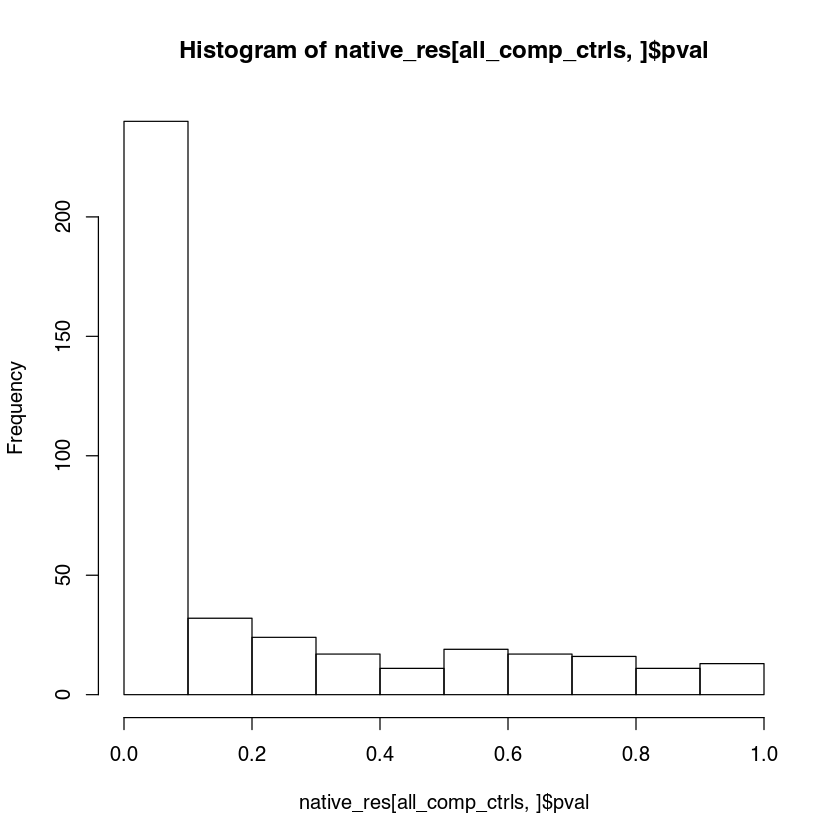

In [39]:
hist(native_res[all_comp_ctrls,]$pval)

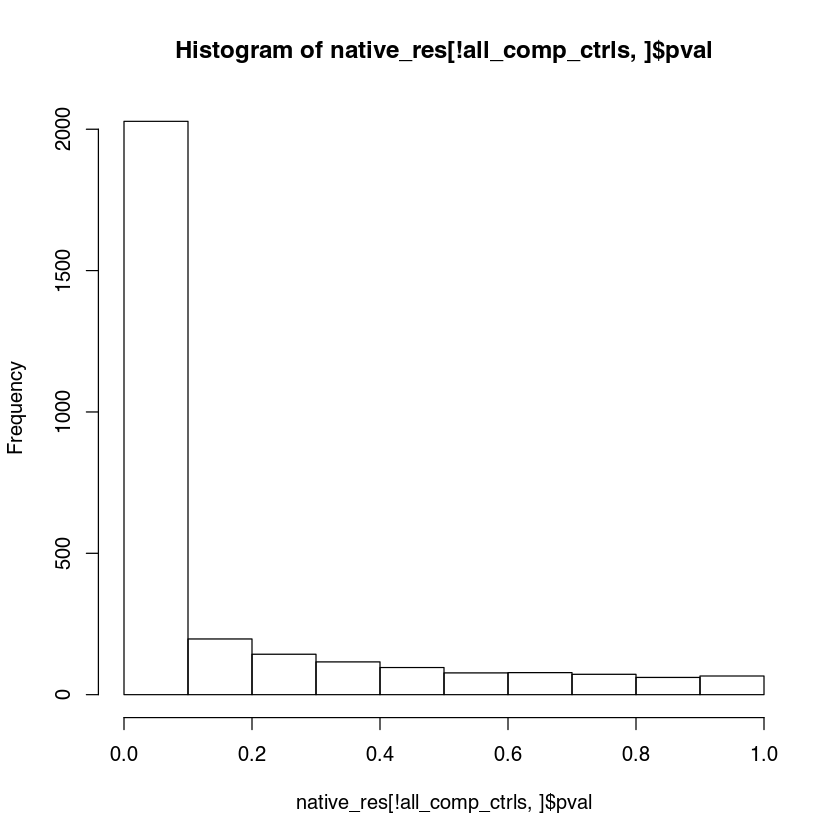

In [40]:
hist(native_res[!all_comp_ctrls,]$pval)

In [41]:
write.table(native_res, file = "../../../data/02__mpra/02__activs/native_results.txt", sep = "\t",
            quote = FALSE)

## 4. run model to compare seq / condition interactions

In [42]:
# note 13 will change depending how many barcodes there are per element
all_rna_cols$depth <- rep(rna_depths, each=26)

In [43]:
# create MPRA object
obj1 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = all_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = all_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [44]:
obj1 <- setDepthFactors(obj1, dnaDepth = all_comp_dna_cols$depth, rnaDepth = all_rna_cols$depth)

In [45]:
head(all_rna_cols)

,X,index,condition,barcode,seq,depth
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human,1
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse,1
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human,1
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse,1
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human,1
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse,1


In [46]:
obj1 <- analyzeComparative(obj = obj1, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq + condition+ seq:condition, 
                           reducedDesign = ~ seq + condition) 

Fitting controls-based background model...
iter:2	log-likelihood:-199403401.069438
iter:3	log-likelihood:-199366318.358132
iter:4	log-likelihood:-199340496.517983
iter:5	log-likelihood:-199319349.495124
iter:6	log-likelihood:-199302530.730983
iter:7	log-likelihood:-199289599.65189
iter:8	log-likelihood:-199280040.647261
iter:9	log-likelihood:-199273362.38376
iter:10	log-likelihood:-199269105.819984
iter:11	log-likelihood:-199266822.161445
iter:12	log-likelihood:-199266213.120842
iter:13	log-likelihood:-199266866.337728
Fitting model...
Fitting reduced model...
Analysis Done!


In [47]:
int_res <- testLrt(obj1)
head(int_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,2.517928e-02,0.873921162,0.9911147,1,14,9,8,-5.077980e-02
h.3__divergent__m.2__antisense__tile1,7.297051e-01,0.392978782,0.9084451,1,13,9,8,-4.056293e-01
h.4__antisense__m.3__protein_coding__tile1,4.309350e-01,0.511530516,0.9608128,1,14,9,8,-2.107316e-01
h.5__intergenic__m.4__intergenic__tile1,7.187187e+00,0.007342598,0.1520511,1,14,9,8,-7.409127e-01
h.6__intergenic__m.4__intergenic__tile1,4.289695e+00,0.038344054,0.3798490,1,14,9,8,-5.284636e-01
h.7__divergent__m.5__divergent__tile1,2.213339e-06,0.998812964,1.0000000,1,14,9,8,9.271885e-05


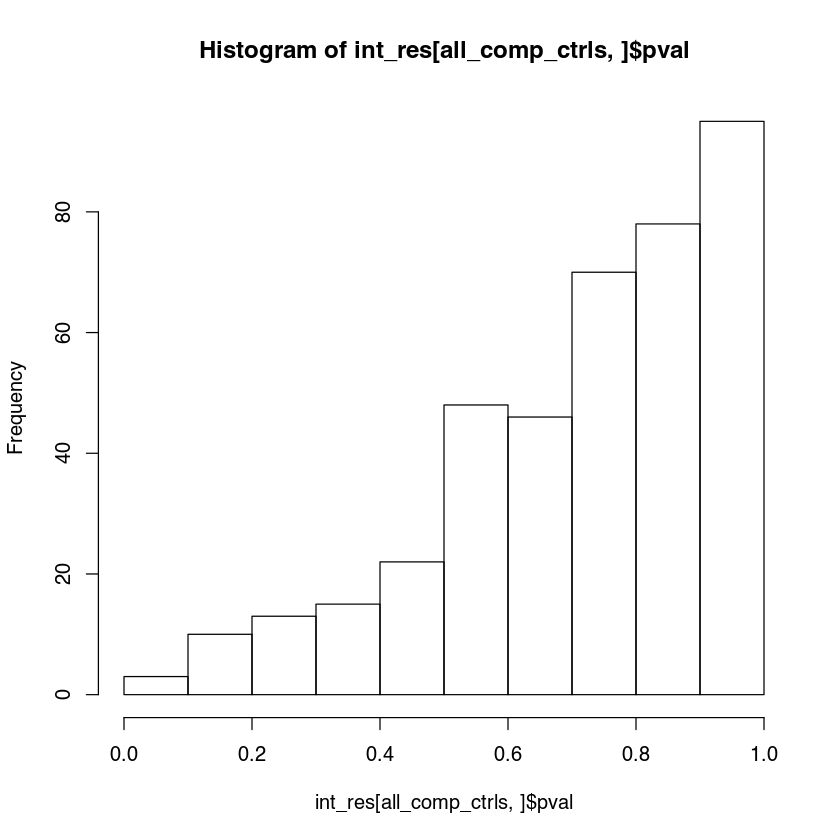

In [48]:
hist(int_res[all_comp_ctrls,]$pval)

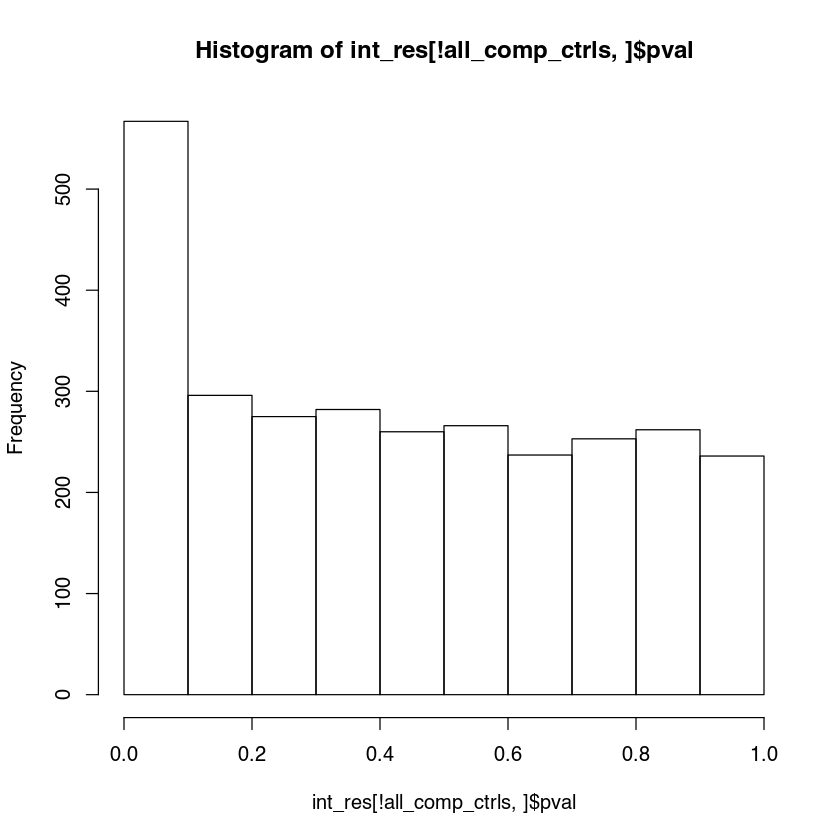

In [49]:
hist(int_res[!all_comp_ctrls,]$pval)

In [50]:
write.table(int_res, file = "../../../data/02__mpra/02__activs/cis_trans_interaction_results.txt", sep = "\t",
            quote = FALSE)

## 5. run model to compare seqs in HUES64

In [51]:
rna_cols_depth

,id,condition,sample,depth
,<fct>,<fct>,<fct>,<dbl>
HUES64_rep1,HUES64_rep1,HUES64,1,1.0000000
HUES64_rep2,HUES64_rep2,HUES64,2,0.6751932
HUES64_rep3,HUES64_rep3,HUES64,3,0.7720110
mESC_rep1,mESC_rep1,mESC,1,0.3075865
mESC_rep2,mESC_rep2,mESC,2,0.3853071
mESC_rep3,mESC_rep3,mESC,3,0.3660570


In [52]:
hues64_depths <- rna_depths[1:3]
hues64_depths

[1] 1.0000000 0.6751932 0.7720110

In [53]:
# note 13 will change depending how many barcodes there are per element
hues64_rna_cols$depth <- rep(hues64_depths, each=26)

In [54]:
# create MPRA object
obj2 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = hues64_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = hues64_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [55]:
obj2 <- setDepthFactors(obj2, dnaDepth = all_comp_dna_cols$depth, rnaDepth = hues64_rna_cols$depth)

In [56]:
obj2 <- analyzeComparative(obj = obj2, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-105313328.918408
iter:3	log-likelihood:-105255373.152862
iter:4	log-likelihood:-105215172.498532
iter:5	log-likelihood:-105190458.57503
iter:6	log-likelihood:-105178528.705004
iter:7	log-likelihood:-105176536.252202
iter:8	log-likelihood:-105181737.985697
Fitting model...
Fitting reduced model...
Analysis Done!


In [57]:
hues64_res <- testLrt(obj2)
head(hues64_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,0.111611,7.383175e-01,8.002440e-01,1,14,5,4,-0.08644337
h.3__divergent__m.2__antisense__tile1,21.254288,4.022096e-06,1.771423e-05,1,13,5,4,1.80181121
h.4__antisense__m.3__protein_coding__tile1,1.225934,2.681992e-01,3.488788e-01,1,14,5,4,0.29609237
h.5__intergenic__m.4__intergenic__tile1,5.180678,2.283941e-02,4.213978e-02,1,14,5,4,-0.57202562
h.6__intergenic__m.4__intergenic__tile1,36.164823,1.813141e-09,1.590792e-08,1,14,5,4,-1.45671675
h.7__divergent__m.5__divergent__tile1,1.262046,2.612641e-01,3.414561e-01,1,14,5,4,-0.23025028


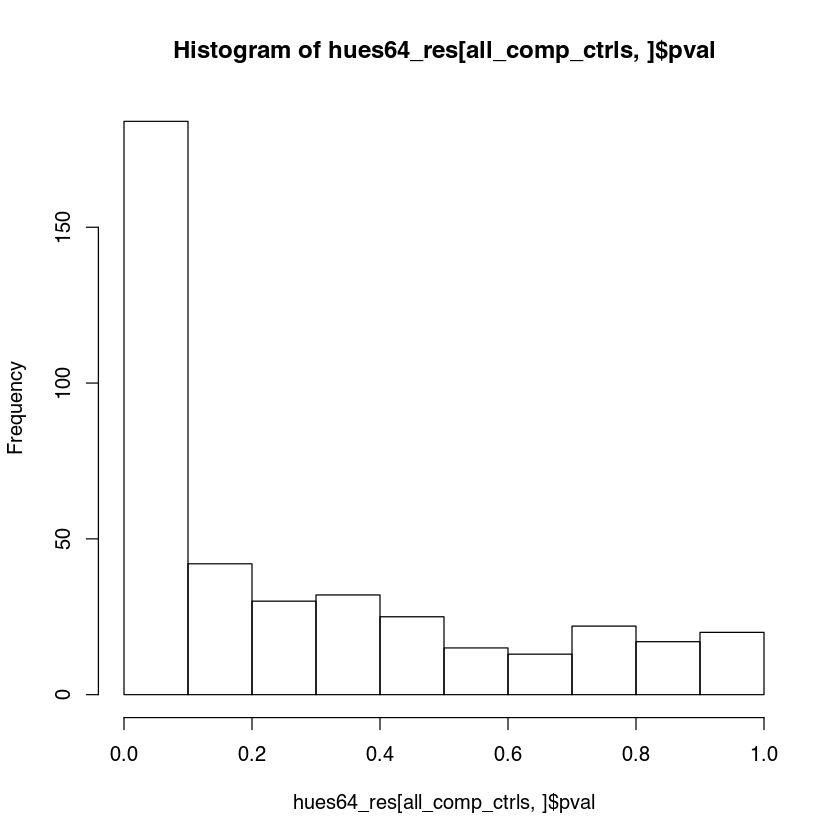

In [58]:
hist(hues64_res[all_comp_ctrls,]$pval)

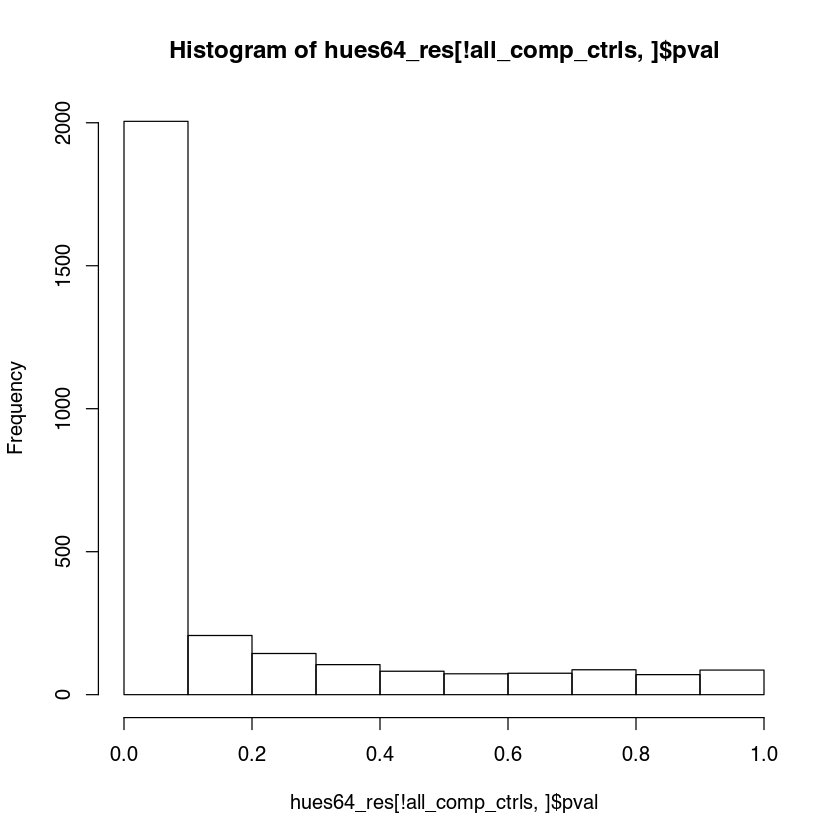

In [59]:
hist(hues64_res[!all_comp_ctrls,]$pval)

In [60]:
write.table(hues64_res, file = "../../../data/02__mpra/02__activs/HUES64_cis_results.txt", sep = "\t",
            quote = FALSE)

## 6. run model to compare seqs in mESC

In [61]:
# note 13 will change depending how many barcodes there are per element
mesc_depths <- rna_depths[4:6]
mesc_rna_cols$depth <- rep(mesc_depths, each=26)

In [62]:
# create MPRA object
obj3 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mesc_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mesc_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [63]:
obj3 <- setDepthFactors(obj3, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mesc_rna_cols$depth)

In [64]:
obj3 <- analyzeComparative(obj = obj3, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-94193006.5813085
iter:3	log-likelihood:-94160364.8181558
iter:4	log-likelihood:-94139364.1458782
iter:5	log-likelihood:-94127170.9159686
iter:6	log-likelihood:-94121434.8057448
iter:7	log-likelihood:-94120264.6819594
iter:8	log-likelihood:-94122236.0150775
Fitting model...
Fitting reduced model...
Analysis Done!


In [65]:
mesc_res <- testLrt(obj3)
head(mesc_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,0.18211966,6.695579e-01,7.470904e-01,1,14,5,4,-0.12514276
h.3__divergent__m.2__antisense__tile1,10.80618448,1.011616e-03,3.068905e-03,1,13,5,4,1.81647087
h.4__antisense__m.3__protein_coding__tile1,0.02968463,8.632078e-01,9.035789e-01,1,14,5,4,0.04634519
h.5__intergenic__m.4__intergenic__tile1,31.55221897,1.941484e-08,1.788096e-07,1,14,5,4,-1.23381499
h.6__intergenic__m.4__intergenic__tile1,67.85532497,1.759428e-16,9.988097e-15,1,14,5,4,-1.89815933
h.7__divergent__m.5__divergent__tile1,1.02013646,3.124866e-01,4.055393e-01,1,14,5,4,-0.24032057


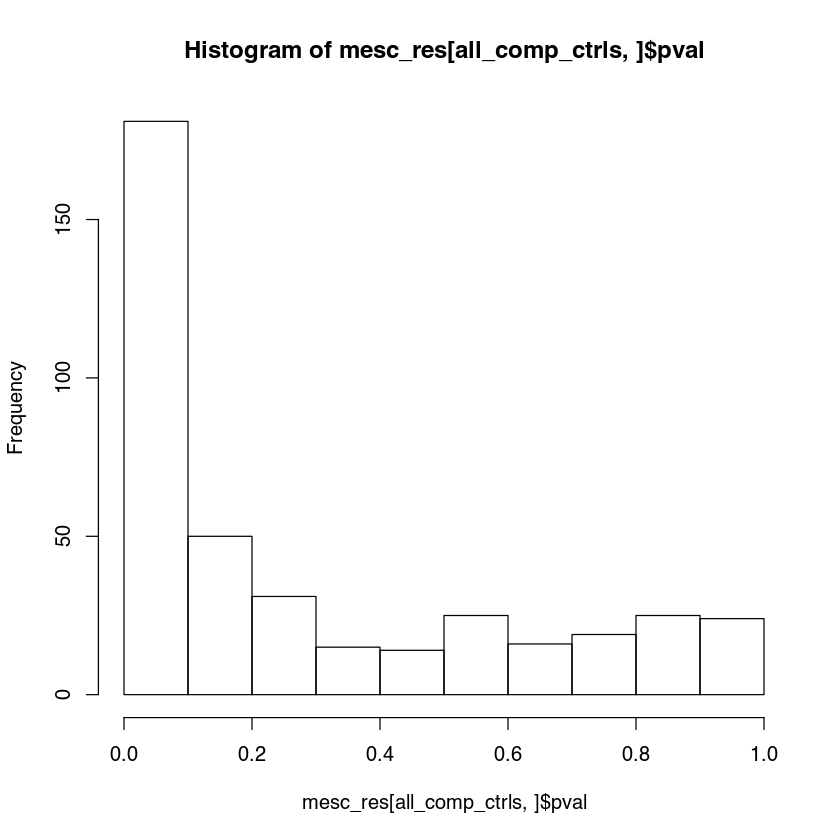

In [66]:
hist(mesc_res[all_comp_ctrls,]$pval)

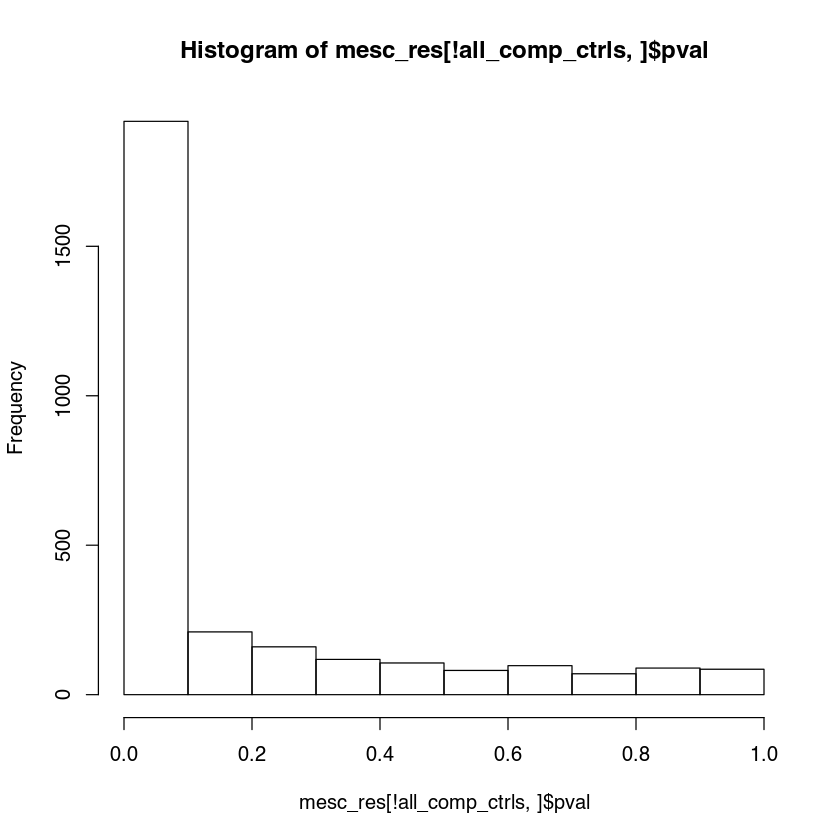

In [67]:
hist(mesc_res[!all_comp_ctrls,]$pval)

In [68]:
write.table(mesc_res, file = "../../../data/02__mpra/02__activs/mESC_cis_results.txt", sep = "\t",
            quote = FALSE)

## 7. run model to compare cells for human seq

In [69]:
# note 13 will change depending how many barcodes there are per element
human_rna_cols$depth <- rep(rna_depths, each=13)

In [70]:
# create MPRA object
obj4 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = human_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = human_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [71]:
obj4 <- setDepthFactors(obj4, dnaDepth = all_comp_dna_cols$depth, rnaDepth = human_rna_cols$depth)

In [72]:
obj4 <- analyzeComparative(obj = obj4, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-94596002.1096042
iter:3	log-likelihood:-94508520.8492015
iter:4	log-likelihood:-94464924.9563534
iter:5	log-likelihood:-94436627.8355265
iter:6	log-likelihood:-94420575.7310871
iter:7	log-likelihood:-94414101.297975
iter:8	log-likelihood:-94414883.3540412
Fitting model...
Fitting reduced model...
Analysis Done!


In [73]:
human_trans_res <- testLrt(obj4)
head(human_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,2.279787,0.13106987,0.272221588,1,14,5,4,-0.3235047
h.3__divergent__m.2__antisense__tile1,1.353634,0.24464378,0.405590438,1,13,5,4,0.4760615
h.4__antisense__m.3__protein_coding__tile1,1.643749,0.19981182,0.361069156,1,14,5,4,0.2702229
h.5__intergenic__m.4__intergenic__tile1,13.790105,0.00020441,0.003373777,1,14,5,4,0.4496683
h.6__intergenic__m.4__intergenic__tile1,4.249918,0.03925223,0.129187506,1,14,5,4,0.2434063
h.7__divergent__m.5__divergent__tile1,4.576337,0.03241645,0.115097375,1,14,5,4,0.2239123


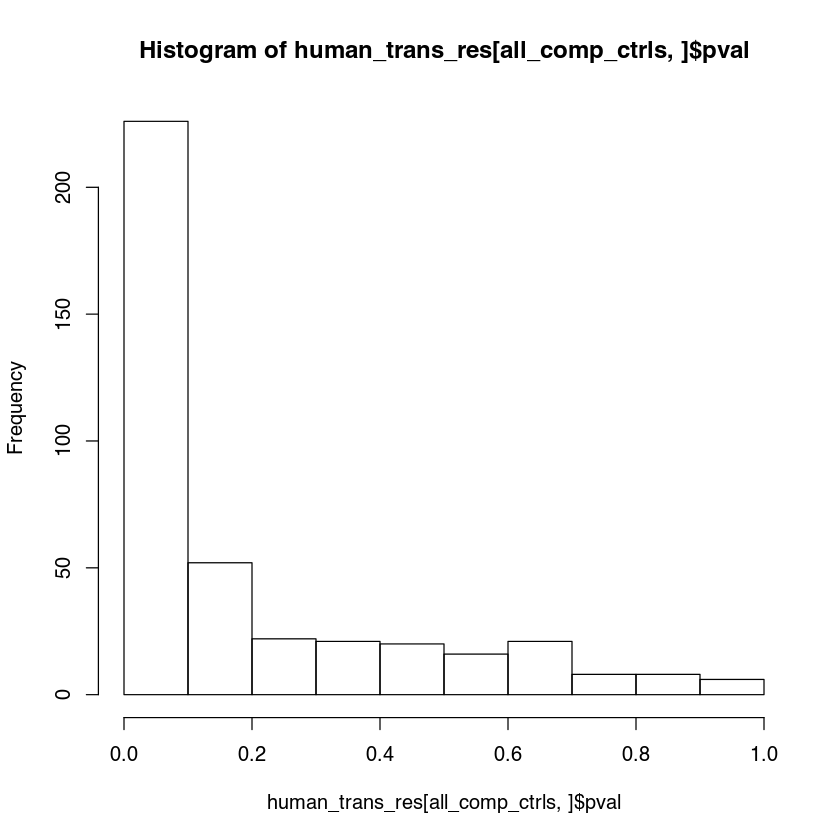

In [74]:
hist(human_trans_res[all_comp_ctrls,]$pval)

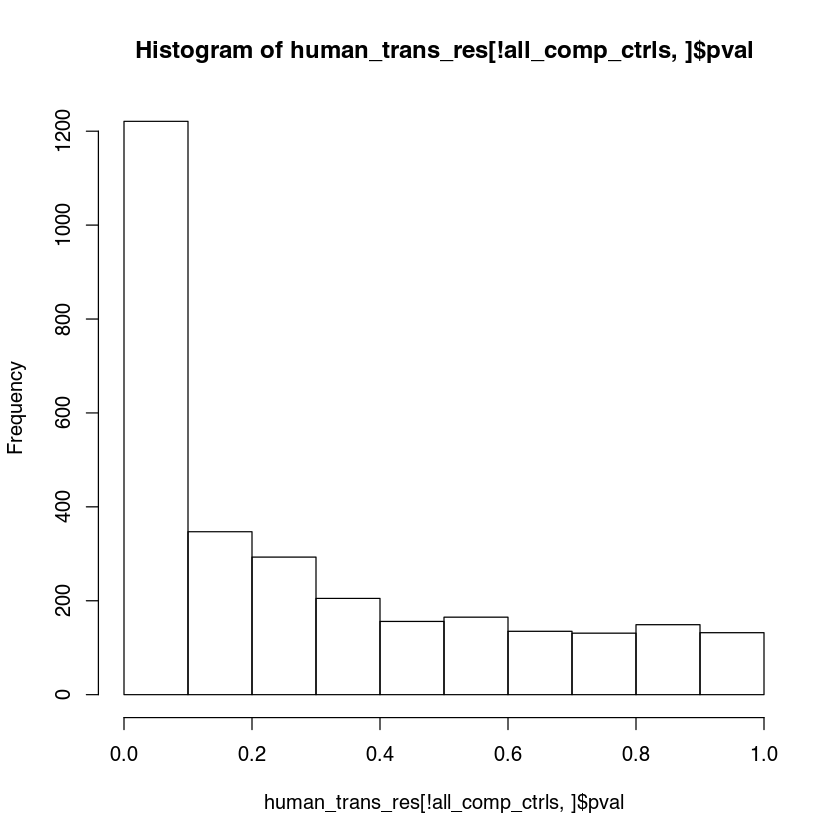

In [75]:
hist(human_trans_res[!all_comp_ctrls,]$pval)

In [76]:
write.table(human_trans_res, file = "../../../data/02__mpra/02__activs/human_trans_results.txt", sep = "\t",
            quote = FALSE)

## 8. run model to compare cells for mouse seq

In [77]:
# note 13 will change depending how many barcodes there are per element
mouse_rna_cols$depth <- rep(rna_depths, each=13)

In [78]:
# create MPRA object
obj5 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mouse_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mouse_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [79]:
obj5 <- setDepthFactors(obj5, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mouse_rna_cols$depth)

In [80]:
obj5 <- analyzeComparative(obj = obj5, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-94761226.4289531
iter:3	log-likelihood:-94702508.9241596
iter:4	log-likelihood:-94674638.636576
iter:5	log-likelihood:-94658170.029929
iter:6	log-likelihood:-94650515.8552102
iter:7	log-likelihood:-94649584.0682399
iter:8	log-likelihood:-94653634.3225107
Fitting model...
Fitting reduced model...
Analysis Done!


In [81]:
mouse_trans_res <- testLrt(obj5)
head(mouse_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__divergent__m.1__divergent__tile1,3.38990160,0.065596864,0.17398564,1,14,5,4,-0.32592023
h.3__divergent__m.2__antisense__tile1,7.04218278,0.007961195,0.04281068,1,13,5,4,0.53347586
h.4__antisense__m.3__protein_coding__tile1,0.09143835,0.762356490,0.85492652,1,14,5,4,0.05570265
h.5__intergenic__m.4__intergenic__tile1,2.01258179,0.155999645,0.30220965,1,14,5,4,-0.27808092
h.6__intergenic__m.4__intergenic__tile1,1.72118544,0.189540524,0.34437499,1,14,5,4,-0.27064569
h.7__divergent__m.5__divergent__tile1,0.65530422,0.418222643,0.58195087,1,14,5,4,0.18007379


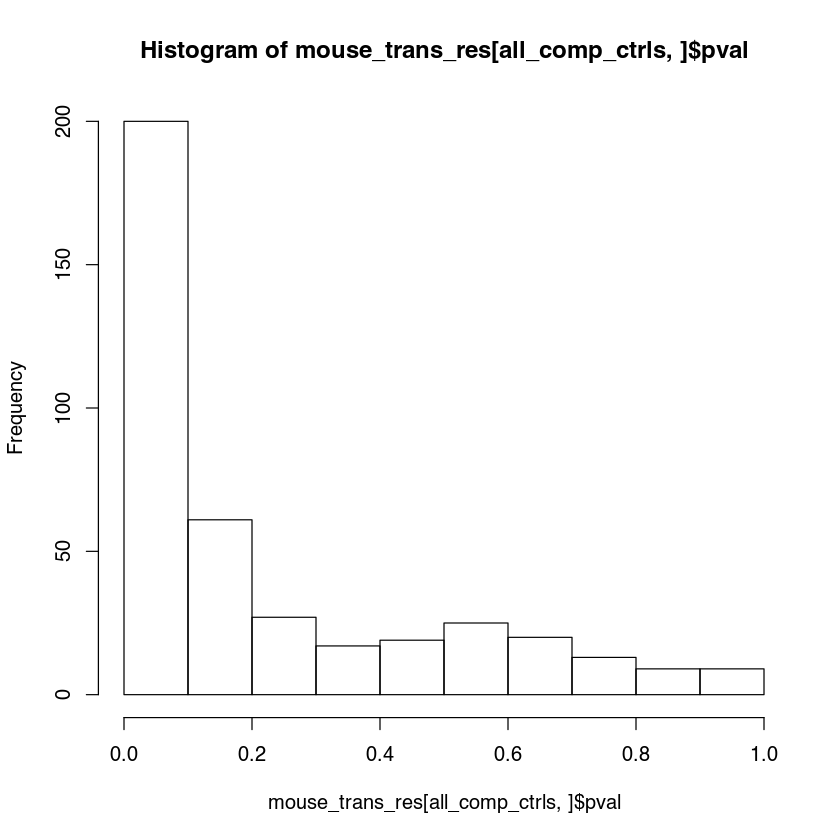

In [82]:
hist(mouse_trans_res[all_comp_ctrls,]$pval)

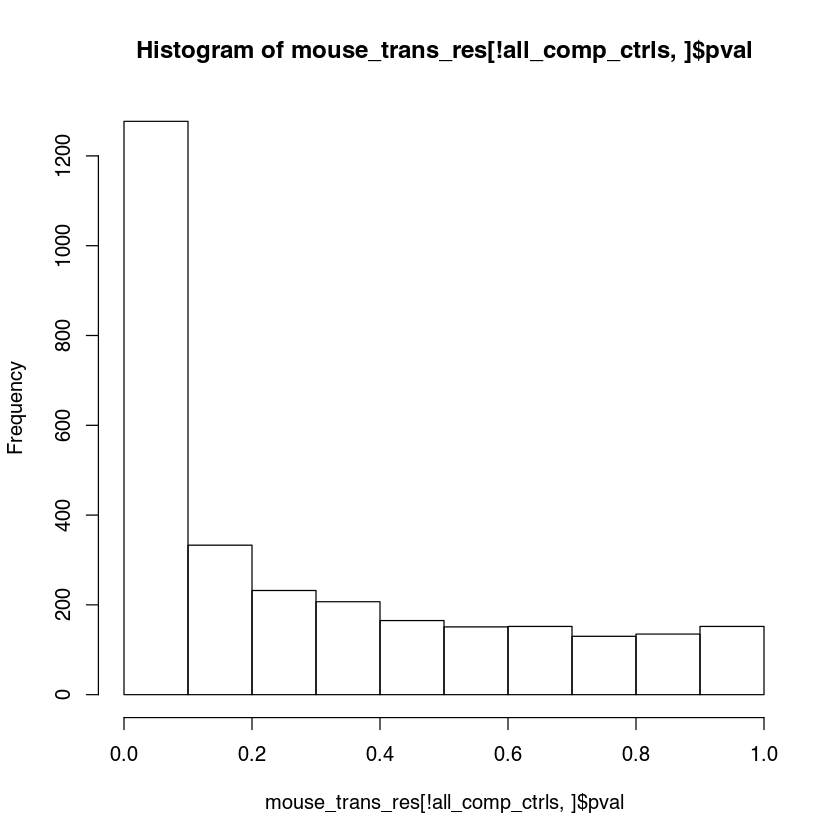

In [83]:
hist(mouse_trans_res[!all_comp_ctrls,]$pval)

In [84]:
write.table(mouse_trans_res, file = "../../../data/02__mpra/02__activs/mouse_trans_results.txt", sep = "\t",
            quote = FALSE)